In [16]:
import time
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.datasets import imdb
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense, GRU, SimpleRNN, Dropout
from keras.constraints import MinMaxNorm
from keras.regularizers import l2
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings("ignore")

In [2]:
max_features = 10000
maxlen = 500  # обмеження кількості слів в тексті
skip_top = 100

# Завантаження тренувальних та тестових даних зі вказанням обмеження на кількість слів
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features, skip_top=skip_top)

# Застосування заздалегідь обраної максимальної довжини до послідовних даних тренувального та тестового наборів
input_train = pad_sequences(input_train, maxlen=maxlen)
input_test = pad_sequences(input_test, maxlen=maxlen)

# EDA

In [3]:
input_train

array([[   0,    0,    0, ...,    2,  178,    2],
       [   0,    0,    0, ...,    2,  145,    2],
       [   0,    0,    0, ...,    2,  129,  113],
       ...,
       [   0,    0,    0, ...,    2, 3586,    2],
       [   0,    0,    0, ...,    2,    2,    2],
       [   0,    0,    0, ...,  204,  131,    2]], dtype=int32)

In [4]:
y_train

array([1, 0, 0, ..., 0, 1, 0])

In [5]:
from collections import OrderedDict

dct = imdb.get_word_index()
sorted_dct = OrderedDict(sorted(dct.items()))

for item in sorted_dct.items():    
    print(item)

('\x08\x08\x08\x08a', 68893)
('\x10own', 70879)
("'", 755)
("''", 17448)
("''a", 57351)
("''after", 64015)
("''bad", 72030)
("''cannibal", 58448)
("''clients''", 80824)
("''dark''", 66872)
("''empire", 52876)
("''family", 85943)
("''gaslight''", 58747)
("''heart''", 75354)
("''high", 66908)
("''holy", 83565)
("''human''", 61364)
("''humans''", 88090)
("''i'm", 61351)
("''if", 62727)
("''inuyasha''", 61770)
("''little''", 58164)
("''maison", 85895)
("''ned''", 62202)
("''negative''", 76149)
("''nice", 57008)
("''oh", 45418)
("''on", 66910)
("''oversexed''", 75509)
("''peeping", 81867)
("''professionals''", 76109)
("''ranma", 44903)
("''raptors''", 70722)
("''return", 55138)
("''saint", 51394)
("''scarface''", 51257)
("''sea", 49404)
("''talent", 84926)
("''terrorists''", 81627)
("''the", 20197)
("''their", 84051)
("''this", 66430)
("''thunderball", 87604)
("''troubled''", 79833)
("''unpleasant", 66417)
("''villain", 71277)
("''voyeur''", 70370)
("''we're", 66244)
("''while''", 65559)
("

In [6]:
print(dct["''bad"])

72030


In [7]:
print(dct["bad"])

75


In [8]:
print(dct["the"])

1


In [9]:
print(dct["'the"])

1062


In [10]:
len(dct)

88584

# Func

In [11]:
def model_learning(batch_sizes:list,
                   epochs: list,
                   models:dict,
                   optimizers:list,
                   max_features,
                   input_train=input_train, 
                   input_test=input_test, 
                   y_train=y_train,
                   y_test=y_test):
    

    summary = []
    hists = {}
    test_acc_rate = {}
    learning_time = {}


    for model_name, model in models.items():
        for optimizer in optimizers:
            model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])
            model.summary()

            for batch_size in batch_sizes:
                for epoch in epochs:
                    model_id = f'{model_name}: {optimizer} opt, {epoch} epochs, batch {batch_size}'
                    print(f'\n\n\033[0;31m\033[1m {model_id} \033[0m')

                    start = time.time()

                    history = model.fit(input_train,
                            y_train,
                            epochs=epoch,
                            batch_size=batch_size,
                            validation_split=0.3,
                            callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                                        patience=5, 
                                                                        restore_best_weights=True
                                                                        )
                                                                        ]
                                                                        )
                    end = time.time() - start
                    print (f'{end} seconds')

                    print('\033[0;36m\033[1m Learning diagrams \033[0m')
                    
                    acc = history.history['acc']
                    val_acc = history.history['val_acc']
                    loss = history.history['loss']
                    val_loss = history.history['val_loss']

                    learning_epochs = range(1, len(acc) + 1)

                    plt.plot(learning_epochs, acc, 'bo', label='Точність на тренуванні')  # Графік точності на тренувальних данних
                    plt.plot(learning_epochs, val_acc, 'b', label='Точність на валідації')  # Графік точності на валідаційних данних
                    plt.title('Точність тренування і валідації')  # Заголовок графіку
                    plt.legend()  # Показати легенду

                    plt.figure()

                    plt.plot(learning_epochs, loss, 'bo', label='Втрати на тренуванні')  # Графік втрат на тренувальних данних
                    plt.plot(learning_epochs, val_loss, 'b', label='Втрати на валідації')  # Графік втрат на валідаційних данних
                    plt.title('Втрати тренування і валідації')  # Заголовок графіку
                    plt.legend()  # Показати легенду

                    plt.show()  # Відобразити графіки

                    print('\033[0;36m\033[1m Prediction \033[0m')
                    
                    predictions = model.predict(input_test)

                    # Для отримання зрозумілішого вигляду прогнозів, їх можна перетворити в бінарний формат:
                    binary_predictions = [1 if pred > 0.5 else 0 for pred in predictions]

                    # Для порівняння можна вивести деякі прогнозовані значення поряд з фактичними значеннями
                    for i in range(10):
                        print(f"Прогнозоване: {binary_predictions[i]}, Фактичне: {y_test[i]}")

                    # Додатковий крок: Оцінка моделі
                    # Це дасть загальну точність моделі на тестових даних
                    test_loss, test_acc = model.evaluate(input_test, y_test)
                    print('Test Loss: {}'.format(test_loss))
                    print('Test Accuracy: {}'.format(test_acc))

                    hists[model_id] = history
                    test_acc_rate[model_id] = test_acc
                    learning_time[model_id] = end

                    summary.append(f'{model_name}, {optimizer} opt, {epoch} epochs, batch size {batch_size}: '
                                    f'learn time {end} sec, '
                                    f'test acc {test_acc:.4f}, '
                                    f'val acc {val_acc[-1]:.4f}, '
                                    f'train acc {acc[-1]:.4f}, '
                                    f'test loss {test_loss:.4f}, '
                                    f'val loss {val_loss[-1]:.4f}, '
                                    f'train loss {loss[-1]:.4f}'
                                    )
        
    return summary, hists, test_acc_rate

# Tests 1

In [12]:
batch_sizes = [64, 128]
epochs= [30]

optimizers = ['rmsprop', 'adam']

models = {
    'rnn_model' : Sequential([Embedding(max_features, 32, input_length=maxlen),
                              SimpleRNN(units = 64, kernel_regularizer=l2(0.001), activation = "tanh", return_sequences = True),
                              Dropout(0.5),
                              SimpleRNN(units = 32, activation = "tanh", kernel_regularizer=l2(0.001), return_sequences = True),
                              Dropout(0.2),
                              SimpleRNN(units = 10, activation = "sigmoid"),
                              Dropout(0.2),
                              Dense(units = 1)]),    
    'lstm_model': Sequential([Embedding(max_features, 32),
                             LSTM(32, kernel_regularizer=l2(0.001)),
                             Dropout(0.3),
                             Dense(1, activation='sigmoid')]),
    'gru_model' : Sequential([Embedding(max_features, 32),
                              GRU(32, kernel_regularizer=l2(0.001)),
                              Dropout(0.3),
                              Dense(1, activation='sigmoid')]),
    'bd_lmst_model' : Sequential([Embedding(max_features, 32),
                             Bidirectional(LSTM(32, kernel_regularizer=l2(0.001))),
                             Dropout (0.3),
                             Dense(1, activation='sigmoid')]),
    "deep_bd_lmst_model" : Sequential([Embedding(max_features, 32),
                                 Bidirectional(LSTM(32, kernel_regularizer=l2(0.001), return_sequences=True)),
                                 Dropout(0.5),
                                 Bidirectional(LSTM(32)),
                                 Dropout(0.2),
                                 Dense(1, activation='sigmoid')]),
    "deep_bd_gru_model" : Sequential([Embedding(max_features, 32),
                            Bidirectional(GRU(32, kernel_regularizer=l2(0.001), return_sequences=True)),
                            Dropout(0.5),
                            Bidirectional(GRU(32)),
                            Dropout(0.2),
                            Dense(1, activation='sigmoid')]),

}


2024-06-30 10:36:18.353412: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)



 rnn_model: rmsprop opt, 30 epochs, batch 64 
Epoch 1/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 189s 661ms/step - acc: 0.5071 - loss: 3.4255 - val_acc: 0.5423 - val_loss: 0.7744
Epoch 2/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 172s 627ms/step - acc: 0.4961 - loss: 1.6010 - val_acc: 0.4933 - val_loss: 0.7531
Epoch 3/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 169s 619ms/step - acc: 0.5046 - loss: 0.7573 - val_acc: 0.4933 - val_loss: 0.7096
Epoch 4/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 173s 630ms/step - acc: 0.5135 - loss: 0.8317 - val_acc: 0.5711 - val_loss: 0.6820
Epoch 5/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 171s 626ms/step - acc: 0.5898 - loss: 0.6886 - val_acc: 0.7188 - val_loss: 0.5913
Epoch 6/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 172s 626ms/step - acc: 0.6989 - loss: 0.6373 - val_acc: 0.7615 - val_loss: 0.5395
Epoch 7/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 173s 633ms/step - acc: 0.7452 - loss: 0.6806 - val_acc: 0.7352 - val_loss: 0.5482
Epoch 8/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 172s 628ms/step - acc: 0.7578 - loss: 0.6659 - val_acc: 0.

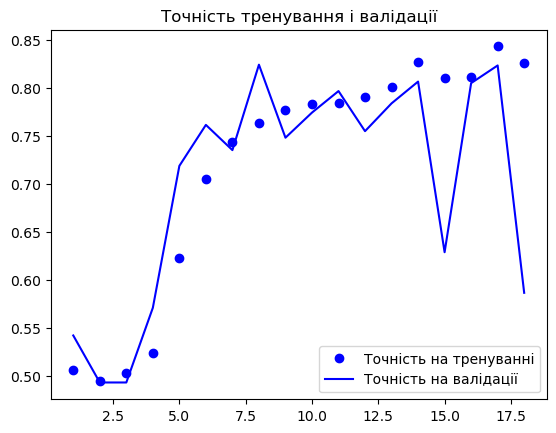

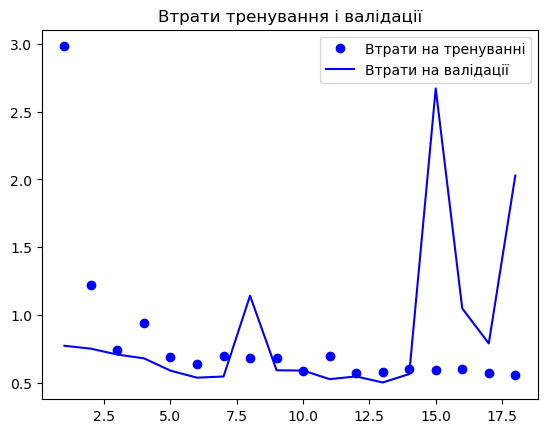

 Prediction 
782/782 ━━━━━━━━━━━━━━━━━━━━ 94s 119ms/step
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 1
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
782/782 ━━━━━━━━━━━━━━━━━━━━ 91s 117ms/step - acc: 0.7755 - loss: 0.5143
Test Loss: 0.5040584206581116
Test Accuracy: 0.7808799743652344


 rnn_model: rmsprop opt, 30 epochs, batch 128 
Epoch 1/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 106s 772ms/step - acc: 0.8211 - loss: 0.4998 - val_acc: 0.8151 - val_loss: 0.4745
Epoch 2/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 105s 767ms/step - acc: 0.7928 - loss: 0.5385 - val_acc: 0.7744 - val_loss: 0.6233
Epoch 3/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 109s 797ms/step - acc: 0.7638 - loss: 0.5728 - val_acc: 0.7296 - val_loss: 0.5754
Epoch 4/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 102s 745ms/step - acc: 0.7809 - loss: 0.5706 - val_acc: 0.796

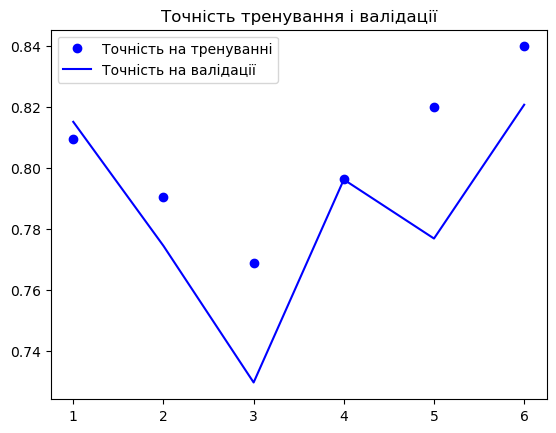

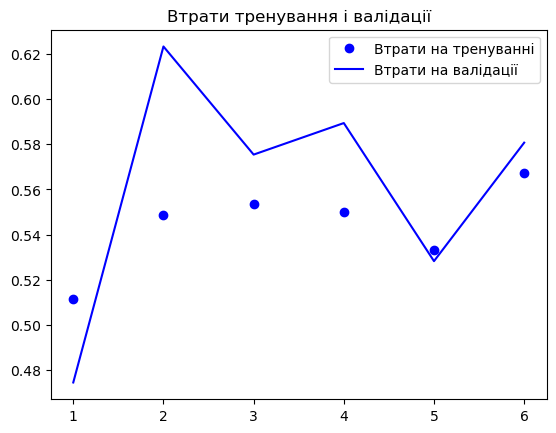

 Prediction 
782/782 ━━━━━━━━━━━━━━━━━━━━ 93s 119ms/step
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
782/782 ━━━━━━━━━━━━━━━━━━━━ 95s 121ms/step - acc: 0.8123 - loss: 0.4819
Test Loss: 0.4770244061946869
Test Accuracy: 0.8127599954605103


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 500, 32)        │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 500, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 500, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 500, 32)        │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 500, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 10)             │           430 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,753 (1.26 MB)

 Trainable params: 329,753 (1.26 MB)

 Non-trainable params: 0 (0.00 B)



 rnn_model: adam opt, 30 epochs, batch 64 
Epoch 1/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 178s 620ms/step - acc: 0.7651 - loss: 1.0714 - val_acc: 0.7820 - val_loss: 0.5454
Epoch 2/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 167s 609ms/step - acc: 0.7431 - loss: 0.6225 - val_acc: 0.6475 - val_loss: 0.6540
Epoch 3/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 168s 615ms/step - acc: 0.6246 - loss: 0.6860 - val_acc: 0.7079 - val_loss: 0.6106
Epoch 4/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 168s 613ms/step - acc: 0.7133 - loss: 0.5956 - val_acc: 0.7955 - val_loss: 0.4986
Epoch 5/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 166s 606ms/step - acc: 0.7987 - loss: 0.5171 - val_acc: 0.6981 - val_loss: 0.6099
Epoch 6/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 169s 617ms/step - acc: 0.8193 - loss: 0.4824 - val_acc: 0.7272 - val_loss: 0.5702
Epoch 7/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 166s 606ms/step - acc: 0.7344 - loss: 0.5739 - val_acc: 0.6503 - val_loss: 0.6686
Epoch 8/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 169s 616ms/step - acc: 0.6602 - loss: 0.6418 - val_acc: 0.720

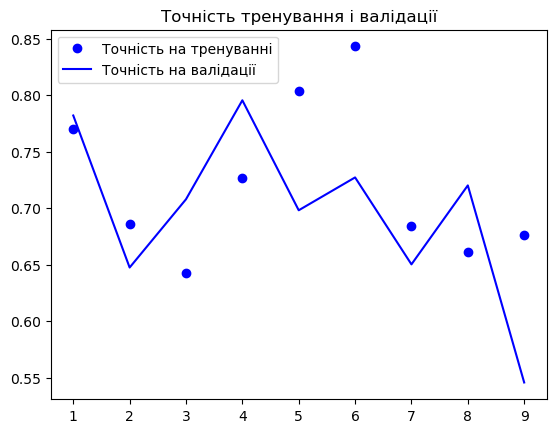

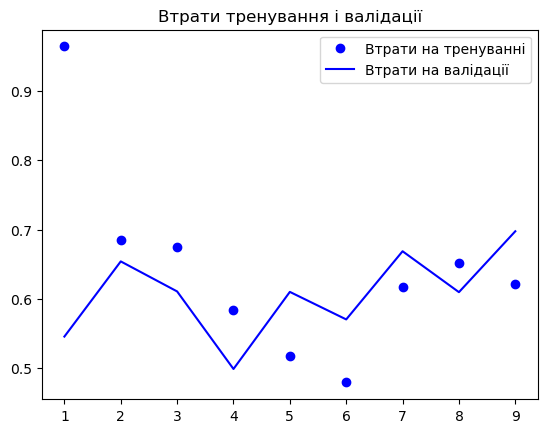

 Prediction 
782/782 ━━━━━━━━━━━━━━━━━━━━ 96s 122ms/step
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 0, Фактичне: 1
Прогнозоване: 0, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
782/782 ━━━━━━━━━━━━━━━━━━━━ 96s 122ms/step - acc: 0.7981 - loss: 0.4966
Test Loss: 0.49658820033073425
Test Accuracy: 0.7973600029945374


 rnn_model: adam opt, 30 epochs, batch 128 
Epoch 1/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 105s 770ms/step - acc: 0.7203 - loss: 0.5946 - val_acc: 0.7063 - val_loss: 0.6075
Epoch 2/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 135s 718ms/step - acc: 0.7565 - loss: 0.5569 - val_acc: 0.7971 - val_loss: 0.5010
Epoch 3/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 104s 758ms/step - acc: 0.7439 - loss: 0.5696 - val_acc: 0.5707 - val_loss: 0.7110
Epoch 4/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 104s 760ms/step - acc: 0.5755 - loss: 0.7087 - val_acc: 0.5767 

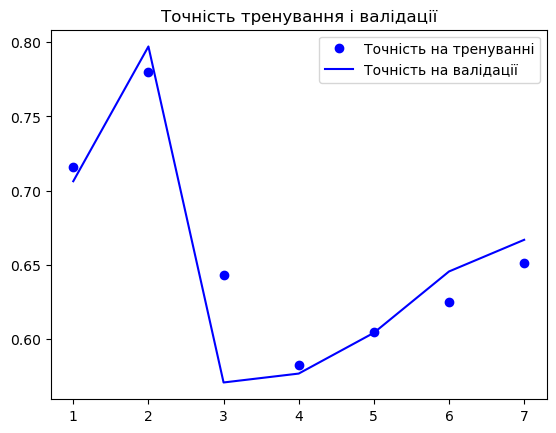

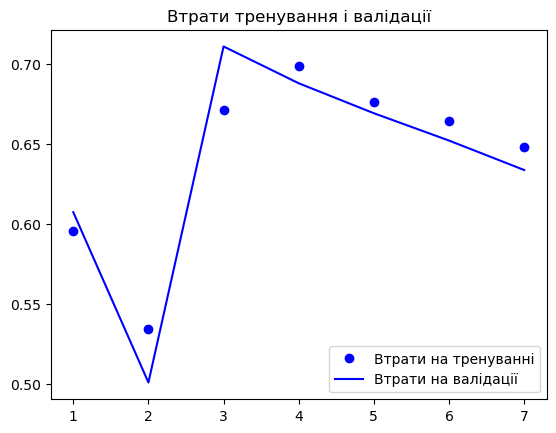

 Prediction 
782/782 ━━━━━━━━━━━━━━━━━━━━ 93s 118ms/step
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 1
Прогнозоване: 0, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
782/782 ━━━━━━━━━━━━━━━━━━━━ 95s 122ms/step - acc: 0.7966 - loss: 0.4980
Test Loss: 0.49600401520729065
Test Accuracy: 0.7976400256156921


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)



 lstm_model: rmsprop opt, 30 epochs, batch 64 
Epoch 1/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 101s 352ms/step - acc: 0.5299 - loss: 0.7189 - val_acc: 0.5733 - val_loss: 0.6606
Epoch 2/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 94s 343ms/step - acc: 0.7014 - loss: 0.6009 - val_acc: 0.7915 - val_loss: 0.4898
Epoch 3/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 137s 326ms/step - acc: 0.7735 - loss: 0.4989 - val_acc: 0.6845 - val_loss: 0.6203
Epoch 4/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 96s 350ms/step - acc: 0.7900 - loss: 0.4703 - val_acc: 0.8112 - val_loss: 0.4411
Epoch 5/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 94s 344ms/step - acc: 0.8192 - loss: 0.4221 - val_acc: 0.7827 - val_loss: 0.4638
Epoch 6/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 94s 343ms/step - acc: 0.8281 - loss: 0.4030 - val_acc: 0.6313 - val_loss: 0.8003
Epoch 7/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 96s 350ms/step - acc: 0.8457 - loss: 0.3783 - val_acc: 0.8384 - val_loss: 0.3759
Epoch 8/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 94s 343ms/step - acc: 0.8463 - loss: 0.3706 - val_acc: 0.8736 

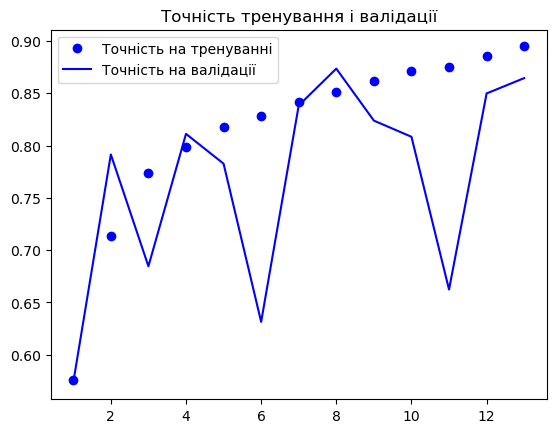

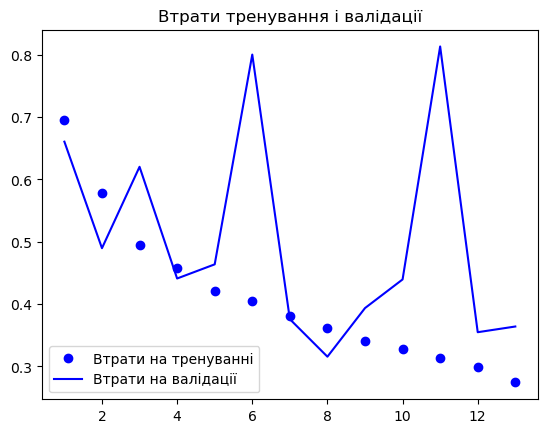

 Prediction 
782/782 ━━━━━━━━━━━━━━━━━━━━ 62s 78ms/step
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
782/782 ━━━━━━━━━━━━━━━━━━━━ 62s 79ms/step - acc: 0.8698 - loss: 0.3237
Test Loss: 0.32337698340415955
Test Accuracy: 0.8699600100517273


 lstm_model: rmsprop opt, 30 epochs, batch 128 
Epoch 1/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 63s 462ms/step - acc: 0.8482 - loss: 0.3822 - val_acc: 0.8187 - val_loss: 0.4114
Epoch 2/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 64s 465ms/step - acc: 0.8540 - loss: 0.3591 - val_acc: 0.7509 - val_loss: 0.5104
Epoch 3/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 65s 478ms/step - acc: 0.8601 - loss: 0.3475 - val_acc: 0.8157 - val_loss: 0.4107
Epoch 4/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 63s 462ms/step - acc: 0.8741 - loss: 0.3229 - val_acc: 0.8511 - 

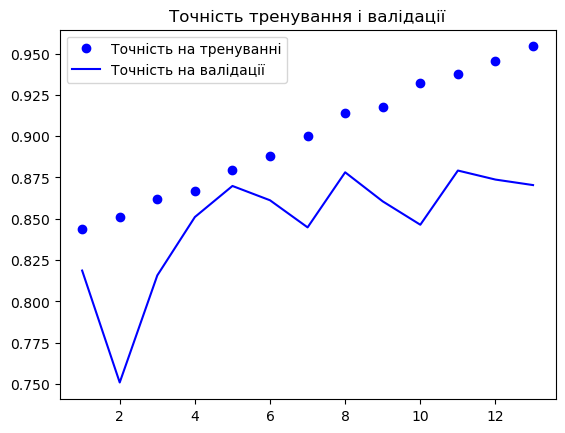

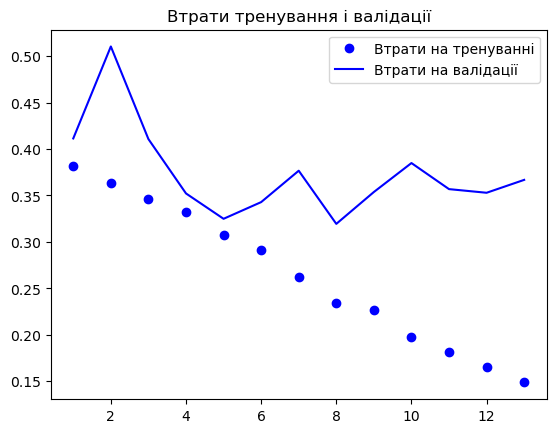

 Prediction 
782/782 ━━━━━━━━━━━━━━━━━━━━ 59s 75ms/step
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
782/782 ━━━━━━━━━━━━━━━━━━━━ 62s 80ms/step - acc: 0.8703 - loss: 0.3313
Test Loss: 0.329041987657547
Test Accuracy: 0.8729199767112732


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 500, 32)        │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 328,353 (1.25 MB)

 Trainable params: 328,353 (1.25 MB)

 Non-trainable params: 0 (0.00 B)



 lstm_model: adam opt, 30 epochs, batch 64 
Epoch 1/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 97s 336ms/step - acc: 0.9254 - loss: 0.2114 - val_acc: 0.8824 - val_loss: 0.3294
Epoch 2/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 89s 326ms/step - acc: 0.9496 - loss: 0.1572 - val_acc: 0.8761 - val_loss: 0.3437
Epoch 3/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 93s 341ms/step - acc: 0.9589 - loss: 0.1289 - val_acc: 0.8727 - val_loss: 0.3720
Epoch 4/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 144s 350ms/step - acc: 0.9660 - loss: 0.1127 - val_acc: 0.8668 - val_loss: 0.4200
Epoch 5/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 90s 329ms/step - acc: 0.9824 - loss: 0.0737 - val_acc: 0.8639 - val_loss: 0.5105
Epoch 6/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 146s 344ms/step - acc: 0.9848 - loss: 0.0649 - val_acc: 0.8525 - val_loss: 0.5336
707.7913281917572 seconds
 Learning diagrams 


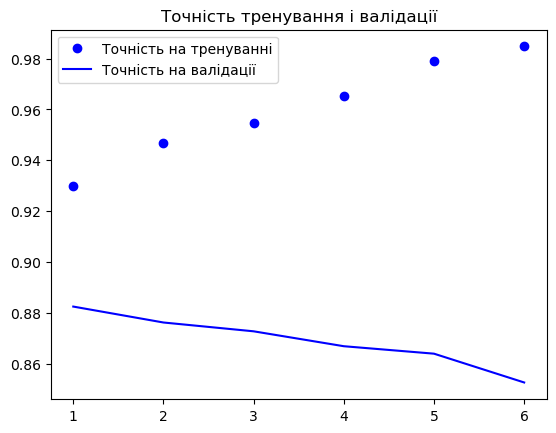

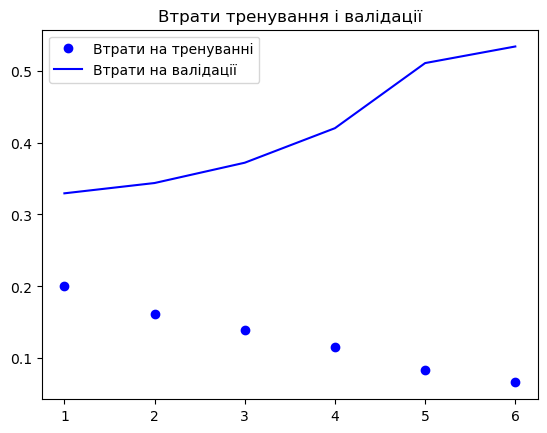

 Prediction 
782/782 ━━━━━━━━━━━━━━━━━━━━ 58s 74ms/step
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
782/782 ━━━━━━━━━━━━━━━━━━━━ 62s 79ms/step - acc: 0.8753 - loss: 0.3511
Test Loss: 0.3497317135334015
Test Accuracy: 0.8737599849700928


 lstm_model: adam opt, 30 epochs, batch 128 
Epoch 1/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 60s 442ms/step - acc: 0.9454 - loss: 0.1616 - val_acc: 0.8807 - val_loss: 0.3495
Epoch 2/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 61s 444ms/step - acc: 0.9615 - loss: 0.1259 - val_acc: 0.8765 - val_loss: 0.3614
Epoch 3/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 60s 435ms/step - acc: 0.9683 - loss: 0.1089 - val_acc: 0.8767 - val_loss: 0.3892
Epoch 4/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 60s 435ms/step - acc: 0.9728 - loss: 0.1007 - val_acc: 0.8663 - val_

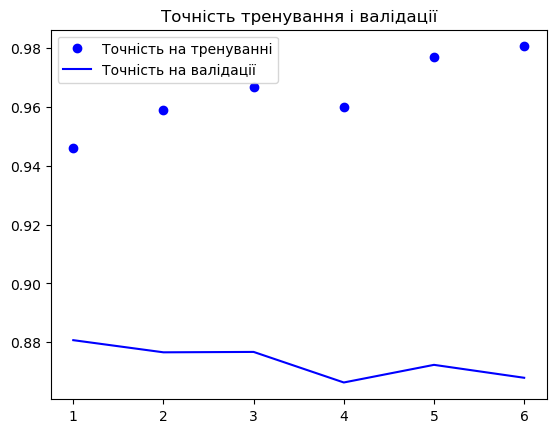

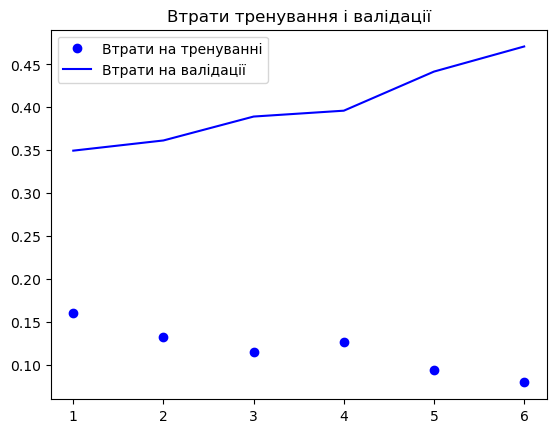

 Prediction 
782/782 ━━━━━━━━━━━━━━━━━━━━ 63s 80ms/step
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
782/782 ━━━━━━━━━━━━━━━━━━━━ 62s 80ms/step - acc: 0.8699 - loss: 0.3742
Test Loss: 0.3736180365085602
Test Accuracy: 0.8697199821472168


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)



 gru_model: rmsprop opt, 30 epochs, batch 64 
Epoch 1/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 113s 393ms/step - acc: 0.5408 - loss: 0.7151 - val_acc: 0.7249 - val_loss: 0.5712
Epoch 2/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 108s 392ms/step - acc: 0.7172 - loss: 0.5753 - val_acc: 0.7427 - val_loss: 0.5263
Epoch 3/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 108s 394ms/step - acc: 0.7720 - loss: 0.4896 - val_acc: 0.7512 - val_loss: 0.5086
Epoch 4/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 108s 393ms/step - acc: 0.7932 - loss: 0.4611 - val_acc: 0.7235 - val_loss: 0.5447
Epoch 5/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 108s 394ms/step - acc: 0.8031 - loss: 0.4344 - val_acc: 0.7971 - val_loss: 0.4508
Epoch 6/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 107s 389ms/step - acc: 0.8250 - loss: 0.4090 - val_acc: 0.8440 - val_loss: 0.3695
Epoch 7/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 108s 393ms/step - acc: 0.8458 - loss: 0.3761 - val_acc: 0.7241 - val_loss: 0.7137
Epoch 8/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 108s 394ms/step - acc: 0.8801 - loss: 0.3066 - val_acc: 0.

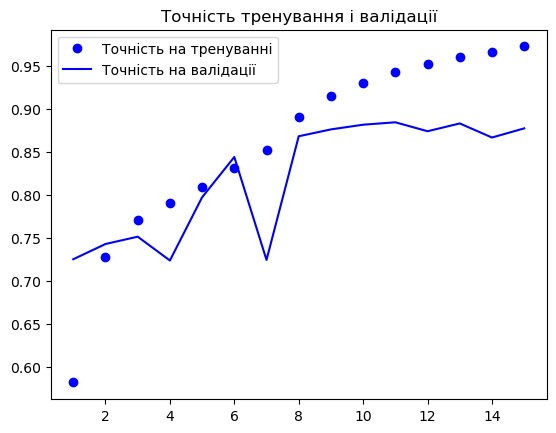

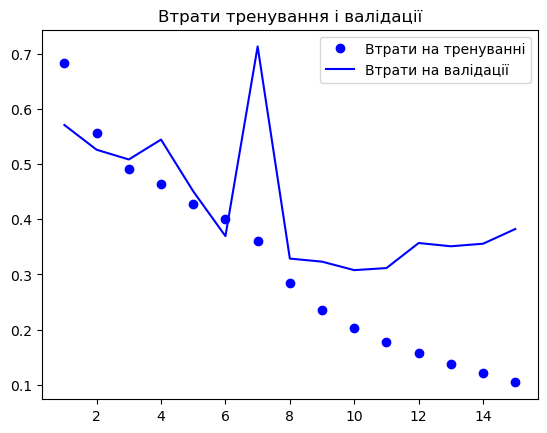

 Prediction 
782/782 ━━━━━━━━━━━━━━━━━━━━ 57s 73ms/step
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
782/782 ━━━━━━━━━━━━━━━━━━━━ 57s 73ms/step - acc: 0.8721 - loss: 0.3218
Test Loss: 0.32080206274986267
Test Accuracy: 0.8730800151824951


 gru_model: rmsprop opt, 30 epochs, batch 128 
Epoch 1/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 73s 536ms/step - acc: 0.9442 - loss: 0.1772 - val_acc: 0.8821 - val_loss: 0.3274
Epoch 2/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 73s 535ms/step - acc: 0.9519 - loss: 0.1536 - val_acc: 0.8812 - val_loss: 0.3164
Epoch 3/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 73s 535ms/step - acc: 0.9619 - loss: 0.1330 - val_acc: 0.8833 - val_loss: 0.3314
Epoch 4/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 71s 517ms/step - acc: 0.9684 - loss: 0.1203 - val_acc: 0.8848 - v

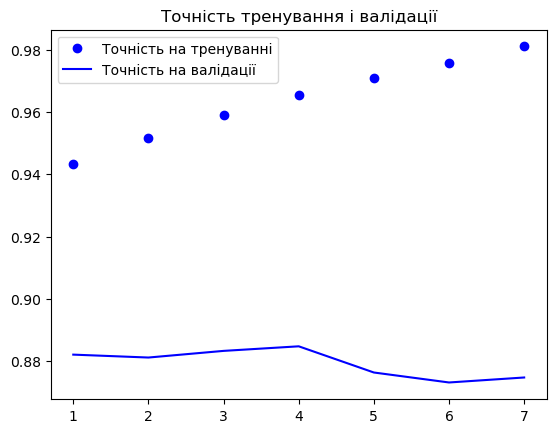

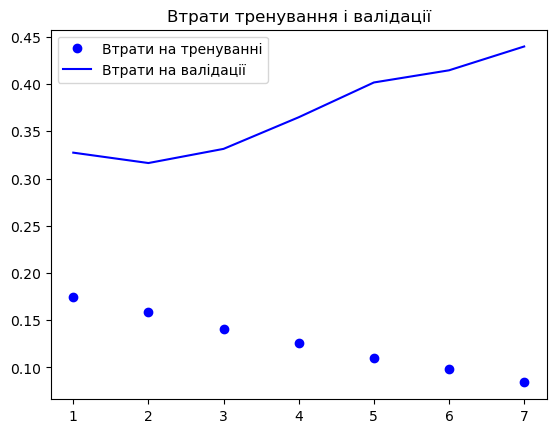

 Prediction 
782/782 ━━━━━━━━━━━━━━━━━━━━ 57s 73ms/step
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
782/782 ━━━━━━━━━━━━━━━━━━━━ 56s 72ms/step - acc: 0.8707 - loss: 0.3376
Test Loss: 0.3361068665981293
Test Accuracy: 0.871399998664856


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 500, 32)        │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 32)             │         6,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 326,369 (1.24 MB)

 Trainable params: 326,369 (1.24 MB)

 Non-trainable params: 0 (0.00 B)



 gru_model: adam opt, 30 epochs, batch 64 
Epoch 1/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 110s 385ms/step - acc: 0.9594 - loss: 0.1392 - val_acc: 0.8820 - val_loss: 0.3573
Epoch 2/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 108s 396ms/step - acc: 0.9749 - loss: 0.1017 - val_acc: 0.8788 - val_loss: 0.3765
Epoch 3/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 106s 388ms/step - acc: 0.9844 - loss: 0.0734 - val_acc: 0.8783 - val_loss: 0.4490
Epoch 4/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 106s 388ms/step - acc: 0.9929 - loss: 0.0487 - val_acc: 0.8713 - val_loss: 0.5375
Epoch 5/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 108s 395ms/step - acc: 0.9963 - loss: 0.0349 - val_acc: 0.8657 - val_loss: 0.5795
Epoch 6/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 106s 388ms/step - acc: 0.9969 - loss: 0.0285 - val_acc: 0.8671 - val_loss: 0.6402
646.4028787612915 seconds
 Learning diagrams 


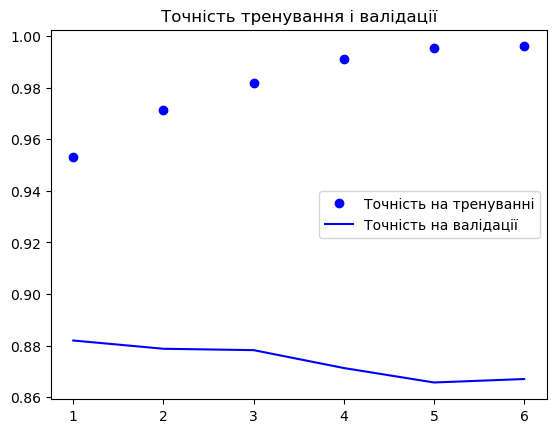

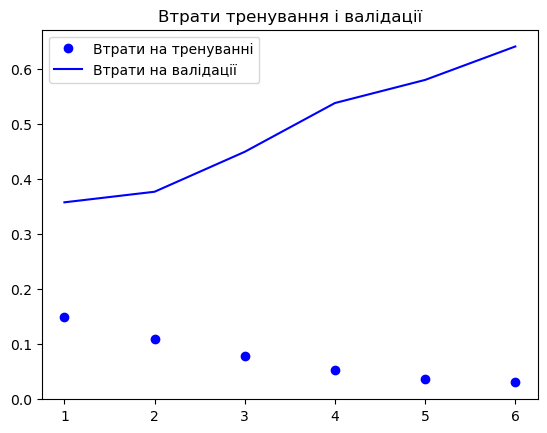

 Prediction 
782/782 ━━━━━━━━━━━━━━━━━━━━ 56s 71ms/step
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
782/782 ━━━━━━━━━━━━━━━━━━━━ 56s 71ms/step - acc: 0.8629 - loss: 0.4064
Test Loss: 0.4060133695602417
Test Accuracy: 0.8632400035858154


 gru_model: adam opt, 30 epochs, batch 128 
Epoch 1/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 71s 521ms/step - acc: 0.9730 - loss: 0.1080 - val_acc: 0.8773 - val_loss: 0.3712
Epoch 2/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 69s 506ms/step - acc: 0.9846 - loss: 0.0727 - val_acc: 0.8735 - val_loss: 0.4240
Epoch 3/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 71s 518ms/step - acc: 0.9919 - loss: 0.0536 - val_acc: 0.8756 - val_loss: 0.5389
Epoch 4/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 69s 504ms/step - acc: 0.9954 - loss: 0.0394 - val_acc: 0.8677 - val_l

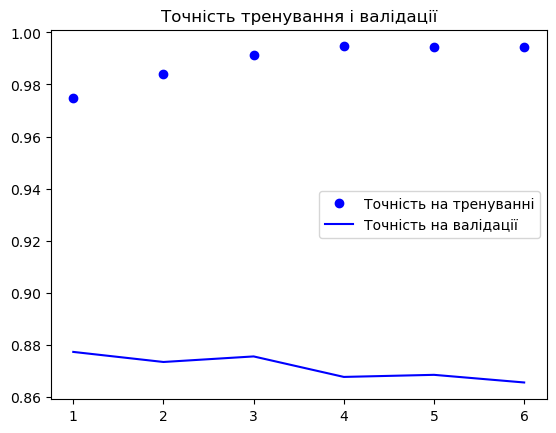

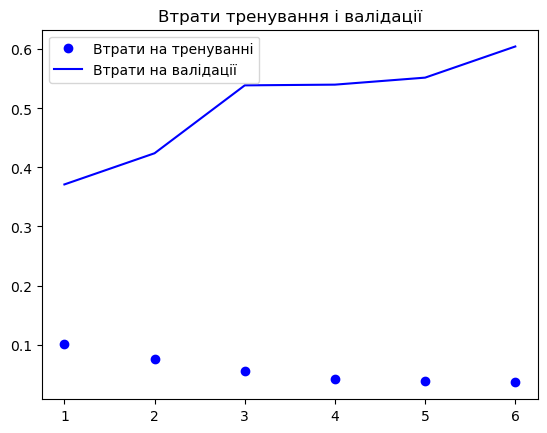

 Prediction 
782/782 ━━━━━━━━━━━━━━━━━━━━ 55s 70ms/step
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
782/782 ━━━━━━━━━━━━━━━━━━━━ 58s 74ms/step - acc: 0.8633 - loss: 0.4162
Test Loss: 0.41177457571029663
Test Accuracy: 0.8641200065612793


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)



 bd_lmst_model: rmsprop opt, 30 epochs, batch 64 
Epoch 1/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 151s 524ms/step - acc: 0.5075 - loss: 0.7531 - val_acc: 0.5640 - val_loss: 0.6868
Epoch 2/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 144s 524ms/step - acc: 0.6292 - loss: 0.6571 - val_acc: 0.5461 - val_loss: 0.8048
Epoch 3/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 196s 504ms/step - acc: 0.7430 - loss: 0.5418 - val_acc: 0.8073 - val_loss: 0.4571
Epoch 4/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 144s 525ms/step - acc: 0.7720 - loss: 0.4895 - val_acc: 0.7251 - val_loss: 0.5372
Epoch 5/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 143s 523ms/step - acc: 0.7982 - loss: 0.4494 - val_acc: 0.7713 - val_loss: 0.4801
Epoch 6/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 145s 529ms/step - acc: 0.8142 - loss: 0.4304 - val_acc: 0.8356 - val_loss: 0.3888
Epoch 7/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 142s 518ms/step - acc: 0.8360 - loss: 0.3933 - val_acc: 0.6703 - val_loss: 0.7221
Epoch 8/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 143s 520ms/step - acc: 0.8443 - loss: 0.3761 - val_acc

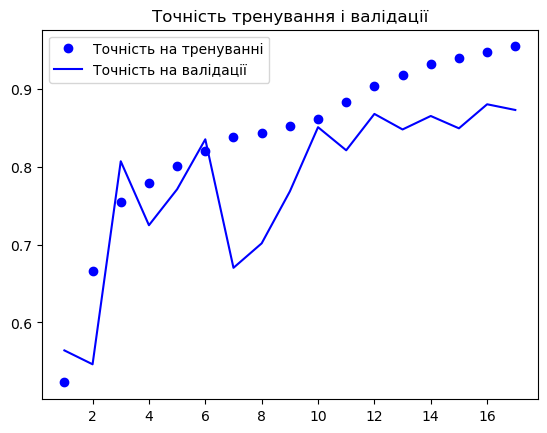

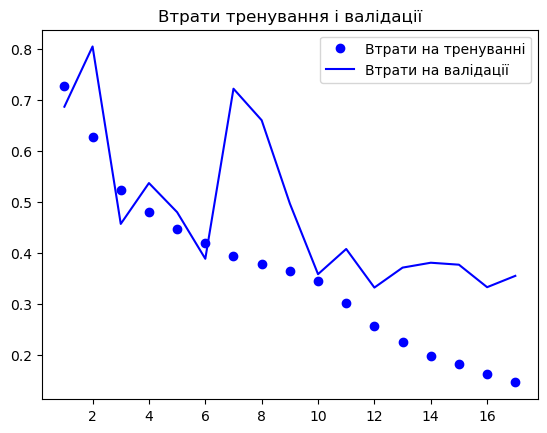

 Prediction 
782/782 ━━━━━━━━━━━━━━━━━━━━ 75s 95ms/step
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
782/782 ━━━━━━━━━━━━━━━━━━━━ 75s 96ms/step - acc: 0.8657 - loss: 0.3402
Test Loss: 0.33887600898742676
Test Accuracy: 0.8666399717330933


 bd_lmst_model: rmsprop opt, 30 epochs, batch 128 
Epoch 1/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 96s 700ms/step - acc: 0.9100 - loss: 0.2520 - val_acc: 0.8799 - val_loss: 0.3309
Epoch 2/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 94s 689ms/step - acc: 0.9268 - loss: 0.1989 - val_acc: 0.8797 - val_loss: 0.3141
Epoch 3/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 104s 761ms/step - acc: 0.9363 - loss: 0.1888 - val_acc: 0.8769 - val_loss: 0.3244
Epoch 4/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 94s 691ms/step - acc: 0.9395 - loss: 0.1763 - val_acc: 0.876

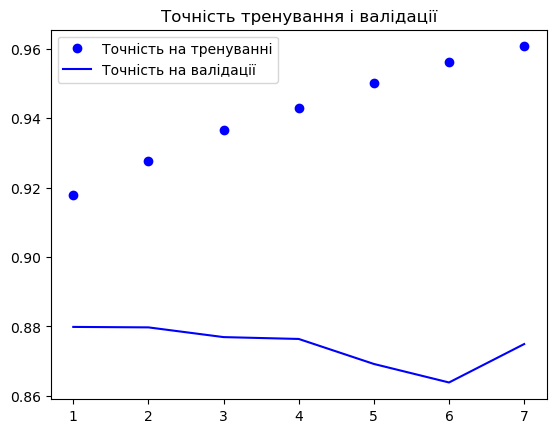

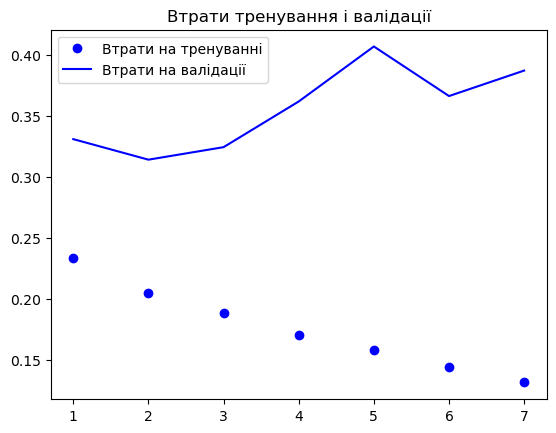

 Prediction 
782/782 ━━━━━━━━━━━━━━━━━━━━ 75s 96ms/step
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
782/782 ━━━━━━━━━━━━━━━━━━━━ 77s 99ms/step - acc: 0.8707 - loss: 0.3336
Test Loss: 0.3333207666873932
Test Accuracy: 0.8710399866104126


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 500, 32)        │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 64)             │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 336,705 (1.28 MB)

 Trainable params: 336,705 (1.28 MB)

 Non-trainable params: 0 (0.00 B)



 bd_lmst_model: adam opt, 30 epochs, batch 64 
Epoch 1/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 145s 504ms/step - acc: 0.9321 - loss: 0.1903 - val_acc: 0.8812 - val_loss: 0.3249
Epoch 2/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 139s 509ms/step - acc: 0.9551 - loss: 0.1495 - val_acc: 0.8779 - val_loss: 0.3442
Epoch 3/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 137s 501ms/step - acc: 0.9667 - loss: 0.1152 - val_acc: 0.8797 - val_loss: 0.3785
Epoch 4/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 140s 510ms/step - acc: 0.9810 - loss: 0.0823 - val_acc: 0.8664 - val_loss: 0.4719
Epoch 5/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 140s 513ms/step - acc: 0.9866 - loss: 0.0623 - val_acc: 0.8689 - val_loss: 0.4907
Epoch 6/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 140s 509ms/step - acc: 0.9906 - loss: 0.0556 - val_acc: 0.8645 - val_loss: 0.5344
842.0449261665344 seconds
 Learning diagrams 


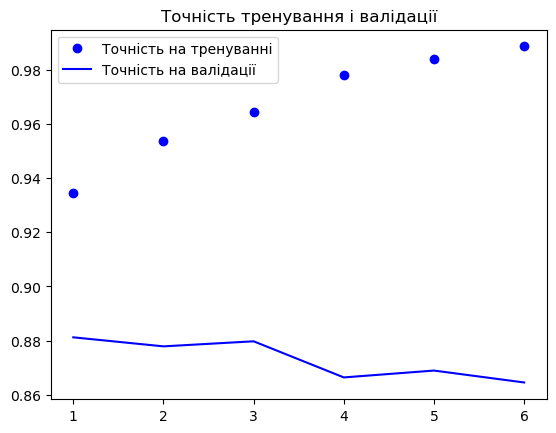

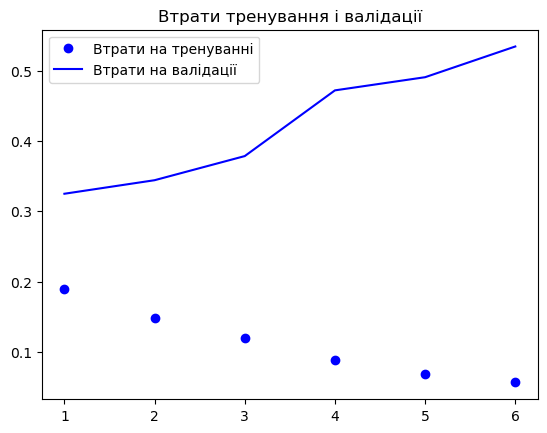

 Prediction 
782/782 ━━━━━━━━━━━━━━━━━━━━ 77s 98ms/step
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
782/782 ━━━━━━━━━━━━━━━━━━━━ 76s 97ms/step - acc: 0.8712 - loss: 0.3515
Test Loss: 0.34903770685195923
Test Accuracy: 0.8718400001525879


 bd_lmst_model: adam opt, 30 epochs, batch 128 
Epoch 1/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 93s 681ms/step - acc: 0.9593 - loss: 0.1384 - val_acc: 0.8695 - val_loss: 0.3571
Epoch 2/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 91s 664ms/step - acc: 0.9642 - loss: 0.1211 - val_acc: 0.8748 - val_loss: 0.3504
Epoch 3/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 138s 636ms/step - acc: 0.9723 - loss: 0.1048 - val_acc: 0.8759 - val_loss: 0.4067
Epoch 4/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 93s 680ms/step - acc: 0.9804 - loss: 0.0860 - val_acc: 0.8713 -

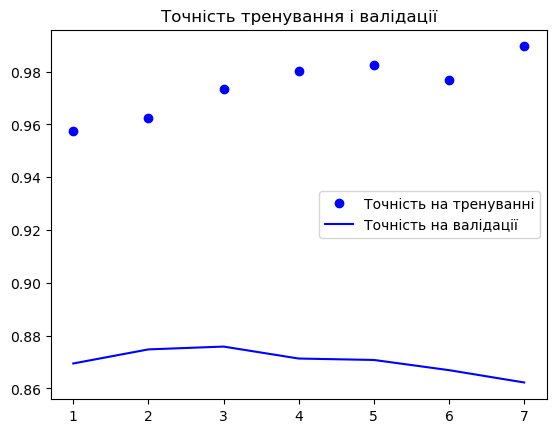

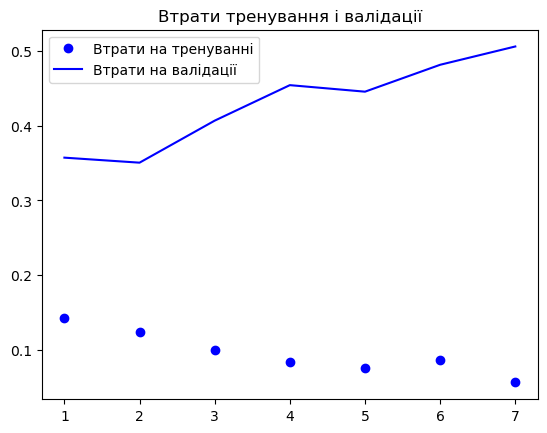

 Prediction 
782/782 ━━━━━━━━━━━━━━━━━━━━ 71s 91ms/step
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
782/782 ━━━━━━━━━━━━━━━━━━━━ 77s 99ms/step - acc: 0.8646 - loss: 0.3898
Test Loss: 0.3882332146167755
Test Accuracy: 0.8659600019454956


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)



 deep_bd_lmst_model: rmsprop opt, 30 epochs, batch 64 
Epoch 1/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 394s 1s/step - acc: 0.5112 - loss: 0.7530 - val_acc: 0.5140 - val_loss: 0.6973
Epoch 2/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 405s 1s/step - acc: 0.5780 - loss: 0.6685 - val_acc: 0.7323 - val_loss: 0.5378
Epoch 3/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 439s 1s/step - acc: 0.7284 - loss: 0.5484 - val_acc: 0.6884 - val_loss: 0.5645
Epoch 4/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 421s 1s/step - acc: 0.7598 - loss: 0.5094 - val_acc: 0.7989 - val_loss: 0.4470
Epoch 5/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 414s 2s/step - acc: 0.7986 - loss: 0.4517 - val_acc: 0.8011 - val_loss: 0.4469
Epoch 6/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 393s 1s/step - acc: 0.8089 - loss: 0.4323 - val_acc: 0.7093 - val_loss: 0.5671
Epoch 7/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 412s 2s/step - acc: 0.8262 - loss: 0.4087 - val_acc: 0.7048 - val_loss: 0.6976
Epoch 8/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 402s 1s/step - acc: 0.8453 - loss: 0.3718 - val_acc: 0.6700 - val_loss

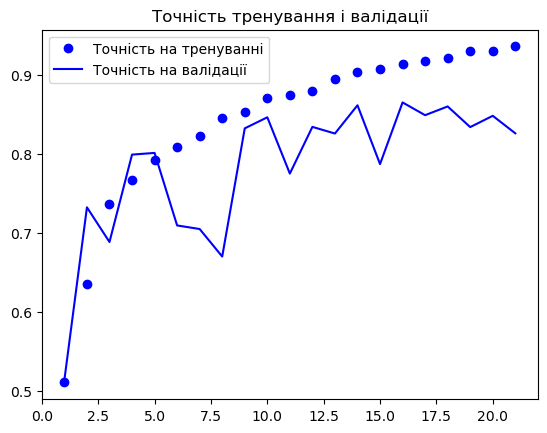

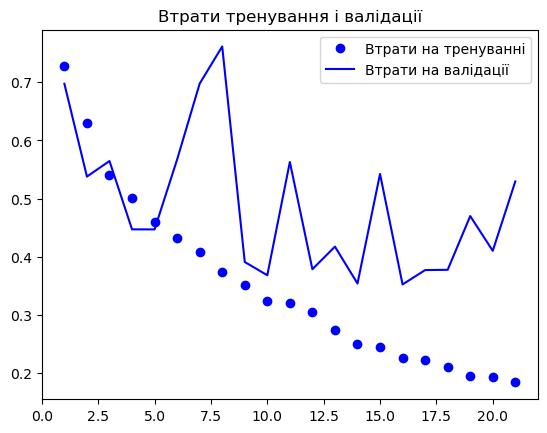

 Prediction 
782/782 ━━━━━━━━━━━━━━━━━━━━ 159s 201ms/step
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
782/782 ━━━━━━━━━━━━━━━━━━━━ 160s 204ms/step - acc: 0.8591 - loss: 0.3605
Test Loss: 0.35834628343582153
Test Accuracy: 0.860759973526001


 deep_bd_lmst_model: rmsprop opt, 30 epochs, batch 128 
Epoch 1/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 307s 2s/step - acc: 0.9096 - loss: 0.2383 - val_acc: 0.8188 - val_loss: 0.4118
Epoch 2/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 300s 2s/step - acc: 0.9223 - loss: 0.2141 - val_acc: 0.8140 - val_loss: 0.4226
Epoch 3/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 286s 2s/step - acc: 0.9082 - loss: 0.2389 - val_acc: 0.8463 - val_loss: 0.3973
Epoch 4/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 317s 2s/step - acc: 0.9341 - loss: 0.1876 - val_acc: 0.8337

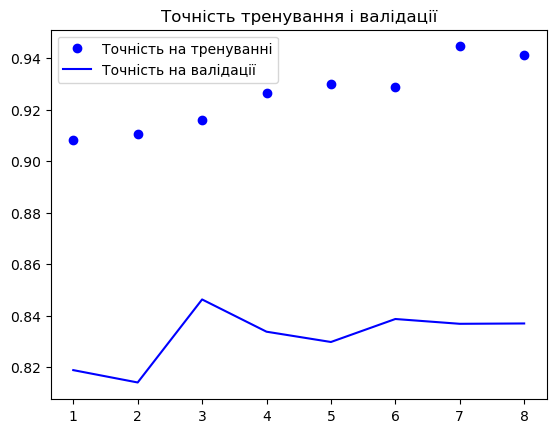

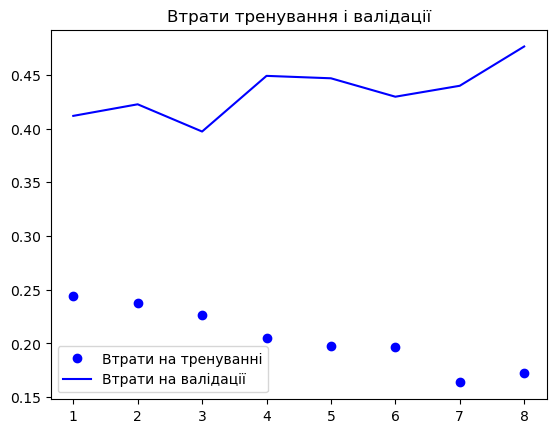

 Prediction 
782/782 ━━━━━━━━━━━━━━━━━━━━ 153s 196ms/step
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 0, Фактичне: 1
782/782 ━━━━━━━━━━━━━━━━━━━━ 160s 204ms/step - acc: 0.8423 - loss: 0.4039
Test Loss: 0.4025355577468872
Test Accuracy: 0.8438400030136108


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 500, 32)        │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 500, 64)        │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 500, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 64)             │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 361,537 (1.38 MB)

 Trainable params: 361,537 (1.38 MB)

 Non-trainable params: 0 (0.00 B)



 deep_bd_lmst_model: adam opt, 30 epochs, batch 64 
Epoch 1/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 411s 1s/step - acc: 0.9468 - loss: 0.1590 - val_acc: 0.8497 - val_loss: 0.3913
Epoch 2/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 401s 1s/step - acc: 0.9636 - loss: 0.1166 - val_acc: 0.8449 - val_loss: 0.4466
Epoch 3/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 460s 2s/step - acc: 0.9693 - loss: 0.1026 - val_acc: 0.8227 - val_loss: 0.5001
Epoch 4/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 421s 1s/step - acc: 0.9760 - loss: 0.0859 - val_acc: 0.8437 - val_loss: 0.5845
Epoch 5/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 457s 2s/step - acc: 0.9827 - loss: 0.0674 - val_acc: 0.8435 - val_loss: 0.6283
Epoch 6/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 435s 1s/step - acc: 0.9838 - loss: 0.0612 - val_acc: 0.8319 - val_loss: 0.6285
2621.4714052677155 seconds
 Learning diagrams 


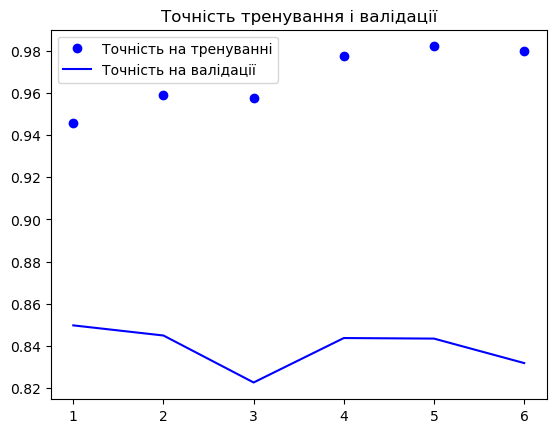

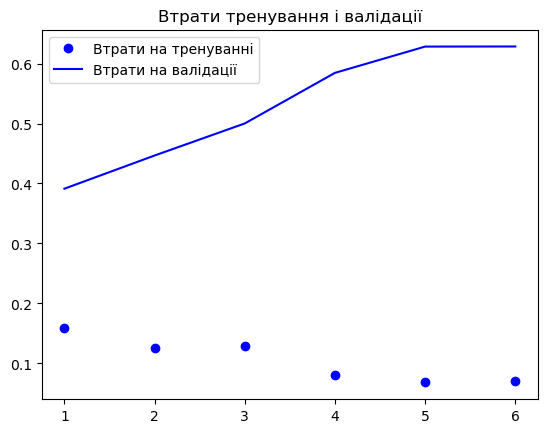

 Prediction 
782/782 ━━━━━━━━━━━━━━━━━━━━ 164s 207ms/step
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
782/782 ━━━━━━━━━━━━━━━━━━━━ 166s 213ms/step - acc: 0.8428 - loss: 0.4007
Test Loss: 0.3976367712020874
Test Accuracy: 0.8447200059890747


 deep_bd_lmst_model: adam opt, 30 epochs, batch 128 
Epoch 1/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 291s 2s/step - acc: 0.9575 - loss: 0.1282 - val_acc: 0.8491 - val_loss: 0.5011
Epoch 2/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 294s 2s/step - acc: 0.9806 - loss: 0.0732 - val_acc: 0.8345 - val_loss: 0.5002
Epoch 3/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 333s 2s/step - acc: 0.9811 - loss: 0.0696 - val_acc: 0.8460 - val_loss: 0.5721
Epoch 4/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 323s 2s/step - acc: 0.9892 - loss: 0.0499 - val_acc: 0.8225 - 

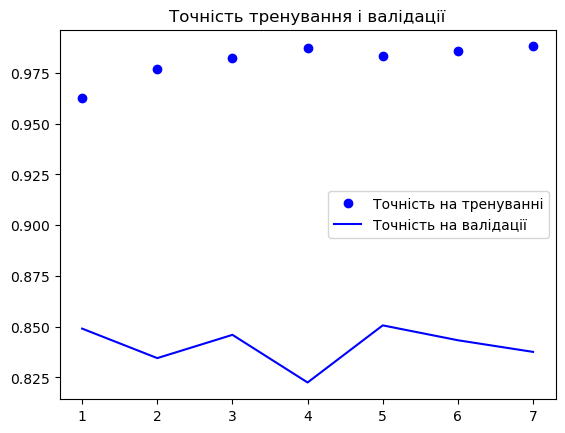

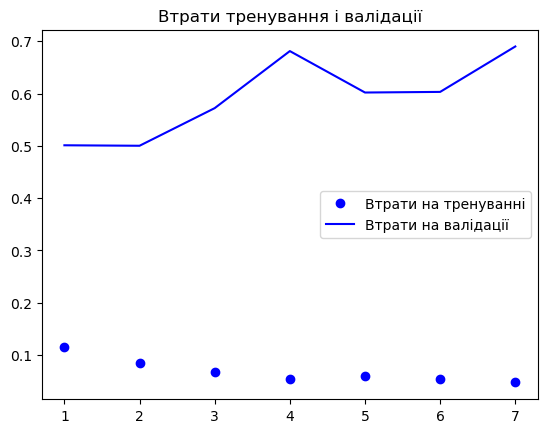

 Prediction 
782/782 ━━━━━━━━━━━━━━━━━━━━ 159s 203ms/step
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 0, Фактичне: 1
782/782 ━━━━━━━━━━━━━━━━━━━━ 172s 220ms/step - acc: 0.8254 - loss: 0.5230
Test Loss: 0.5206925868988037
Test Accuracy: 0.8285199999809265


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)



 deep_bd_gru_model: rmsprop opt, 30 epochs, batch 64 
Epoch 1/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 554s 2s/step - acc: 0.5199 - loss: 0.7466 - val_acc: 0.6037 - val_loss: 0.6501
Epoch 2/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 571s 2s/step - acc: 0.7054 - loss: 0.5636 - val_acc: 0.7009 - val_loss: 0.6106
Epoch 3/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 622s 2s/step - acc: 0.7549 - loss: 0.5193 - val_acc: 0.7284 - val_loss: 0.5379
Epoch 4/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 605s 2s/step - acc: 0.7776 - loss: 0.4830 - val_acc: 0.7388 - val_loss: 0.5152
Epoch 5/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 647s 2s/step - acc: 0.8047 - loss: 0.4394 - val_acc: 0.7783 - val_loss: 0.4837
Epoch 6/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 785s 3s/step - acc: 0.8328 - loss: 0.3964 - val_acc: 0.8419 - val_loss: 0.3801
Epoch 7/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 574s 2s/step - acc: 0.8629 - loss: 0.3456 - val_acc: 0.7987 - val_loss: 0.4842
Epoch 8/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 706s 3s/step - acc: 0.8846 - loss: 0.2950 - val_acc: 0.8271 - val_loss:

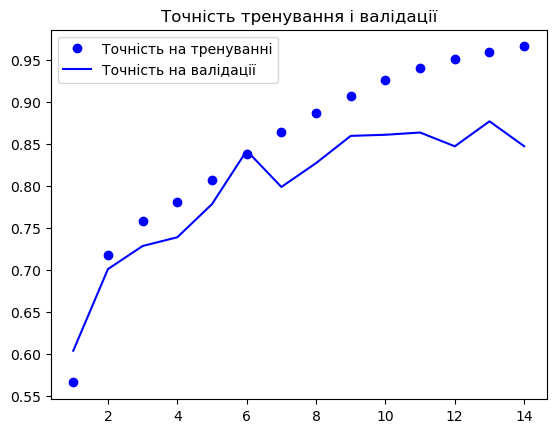

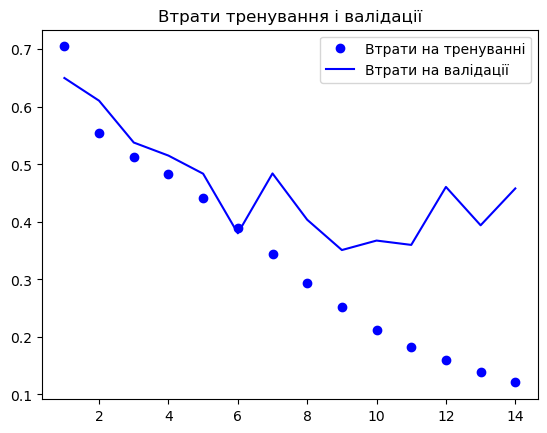

 Prediction 
782/782 ━━━━━━━━━━━━━━━━━━━━ 141s 178ms/step
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
782/782 ━━━━━━━━━━━━━━━━━━━━ 139s 178ms/step - acc: 0.8539 - loss: 0.3598
Test Loss: 0.35724911093711853
Test Accuracy: 0.8550000190734863


 deep_bd_gru_model: rmsprop opt, 30 epochs, batch 128 
Epoch 1/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 283s 2s/step - acc: 0.9326 - loss: 0.2037 - val_acc: 0.8641 - val_loss: 0.3605
Epoch 2/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 287s 2s/step - acc: 0.9384 - loss: 0.1883 - val_acc: 0.8633 - val_loss: 0.3745
Epoch 3/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 307s 2s/step - acc: 0.9501 - loss: 0.1578 - val_acc: 0.8521 - val_loss: 0.4052
Epoch 4/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 284s 2s/step - acc: 0.9574 - loss: 0.1364 - val_acc: 0.8632

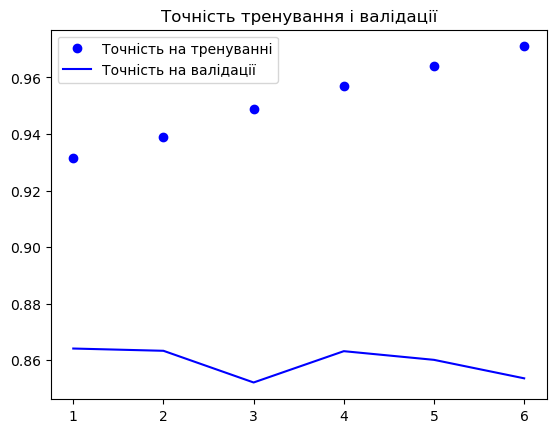

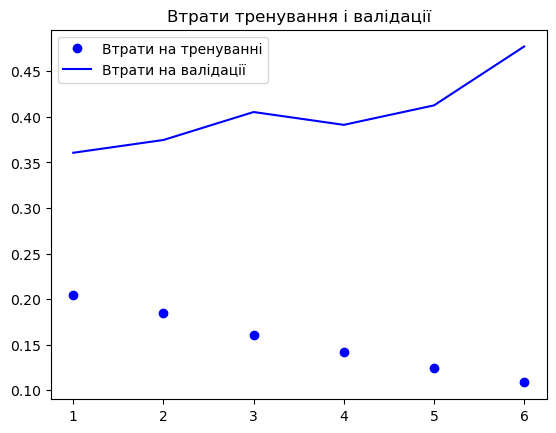

 Prediction 
782/782 ━━━━━━━━━━━━━━━━━━━━ 136s 173ms/step
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
782/782 ━━━━━━━━━━━━━━━━━━━━ 141s 180ms/step - acc: 0.8567 - loss: 0.3744
Test Loss: 0.37303000688552856
Test Accuracy: 0.8578000068664551


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ (None, 500, 32)        │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 500, 64)        │        12,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 500, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 64)             │        18,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 351,553 (1.34 MB)

 Trainable params: 351,553 (1.34 MB)

 Non-trainable params: 0 (0.00 B)



 deep_bd_gru_model: adam opt, 30 epochs, batch 64 
Epoch 1/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 436s 2s/step - acc: 0.9416 - loss: 0.1742 - val_acc: 0.8745 - val_loss: 0.3549
Epoch 2/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 438s 2s/step - acc: 0.9646 - loss: 0.1273 - val_acc: 0.8651 - val_loss: 0.4333
Epoch 3/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 413s 2s/step - acc: 0.9779 - loss: 0.0862 - val_acc: 0.8701 - val_loss: 0.4762
Epoch 4/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 432s 2s/step - acc: 0.9861 - loss: 0.0651 - val_acc: 0.8492 - val_loss: 0.5569
Epoch 5/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 428s 2s/step - acc: 0.9914 - loss: 0.0470 - val_acc: 0.8511 - val_loss: 0.5625
Epoch 6/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 432s 2s/step - acc: 0.9918 - loss: 0.0458 - val_acc: 0.8477 - val_loss: 0.6285
2578.825610399246 seconds
 Learning diagrams 


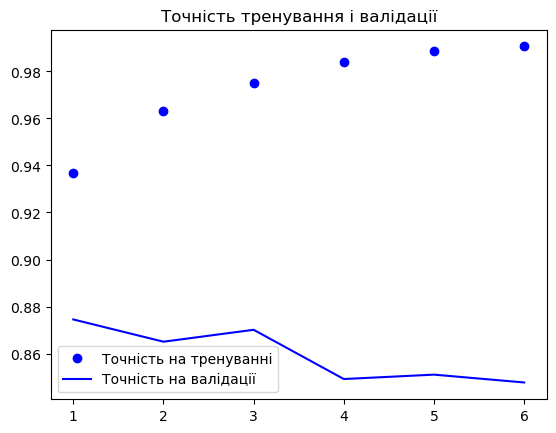

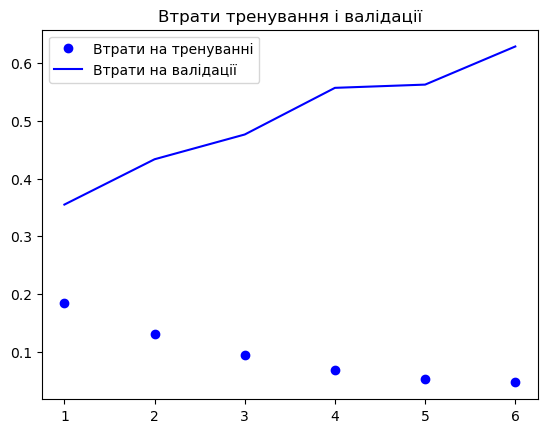

 Prediction 
782/782 ━━━━━━━━━━━━━━━━━━━━ 141s 178ms/step
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 1
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
782/782 ━━━━━━━━━━━━━━━━━━━━ 140s 179ms/step - acc: 0.8608 - loss: 0.3740
Test Loss: 0.3700725734233856
Test Accuracy: 0.8633599877357483


 deep_bd_gru_model: adam opt, 30 epochs, batch 128 
Epoch 1/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 285s 2s/step - acc: 0.9662 - loss: 0.1233 - val_acc: 0.8639 - val_loss: 0.4166
Epoch 2/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 284s 2s/step - acc: 0.9774 - loss: 0.0889 - val_acc: 0.8612 - val_loss: 0.4582
Epoch 3/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 285s 2s/step - acc: 0.9854 - loss: 0.0720 - val_acc: 0.8539 - val_loss: 0.5235
Epoch 4/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 283s 2s/step - acc: 0.9904 - loss: 0.0576 - val_acc: 0.8571 - v

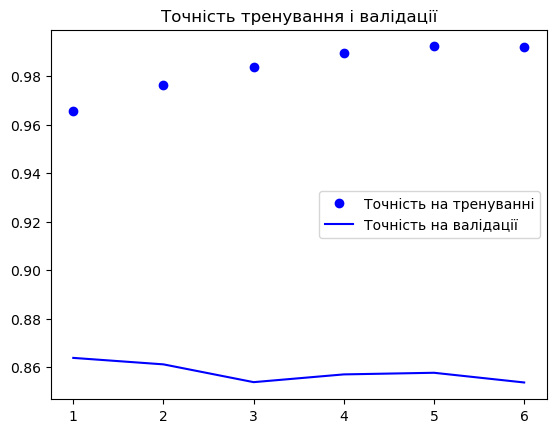

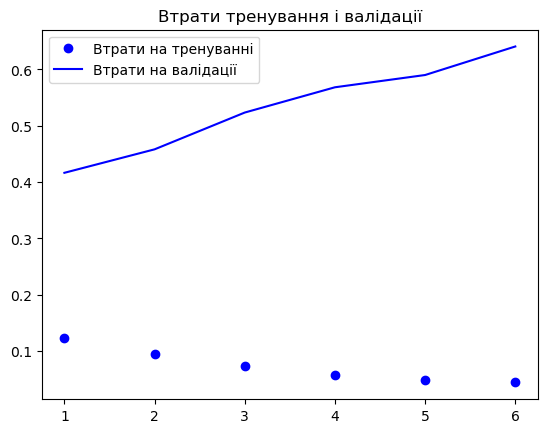

 Prediction 
782/782 ━━━━━━━━━━━━━━━━━━━━ 137s 175ms/step
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
782/782 ━━━━━━━━━━━━━━━━━━━━ 140s 179ms/step - acc: 0.8547 - loss: 0.4439
Test Loss: 0.44080594182014465
Test Accuracy: 0.8543199896812439


In [13]:
summary_1, hists_1, test_acc_rate_1 = model_learning(batch_sizes=batch_sizes, epochs=epochs, models=models, optimizers=optimizers, max_features=max_features)

In [14]:
print('accuracy and loss per model')
for line in summary_1:
    print (line)

accuracy and loss per model
rnn_model, rmsprop opt, 30 epochs, batch size 64: learn time 3140.832895040512 sec, test acc 0.7809, val acc 0.5867, train acc 0.8257, test loss 0.5041, val loss 2.0286, train loss 0.5576
rnn_model, rmsprop opt, 30 epochs, batch size 128: learn time 632.1539332866669 sec, test acc 0.8128, val acc 0.8207, train acc 0.8398, test loss 0.4770, val loss 0.5807, train loss 0.5674
rnn_model, adam opt, 30 epochs, batch size 64: learn time 1552.6598000526428 sec, test acc 0.7974, val acc 0.5457, train acc 0.6760, test loss 0.4966, val loss 0.6975, train loss 0.6213
rnn_model, adam opt, 30 epochs, batch size 128: learn time 758.3167932033539 sec, test acc 0.7976, val acc 0.6668, train acc 0.6515, test loss 0.4960, val loss 0.6338, train loss 0.6481
lstm_model, rmsprop opt, 30 epochs, batch size 64: learn time 1281.951137304306 sec, test acc 0.8700, val acc 0.8645, train acc 0.8948, test loss 0.3234, val loss 0.3641, train loss 0.2743
lstm_model, rmsprop opt, 30 epochs

# Tests 2

models = {
    'rnn_model' : Sequential([Embedding(max_features, 32, input_length=maxlen),
                              SimpleRNN(units = 64, kernel_regularizer=l2(0.001), activation = "tanh", return_sequences = True),
                              Dropout(0.5),
                              SimpleRNN(units = 32, activation = "tanh", kernel_regularizer=l2(0.001), return_sequences = True),
                              Dropout(0.2),
                              SimpleRNN(units = 10, activation = "sigmoid"),
                              Dropout(0.2),
                              Dense(units = 1)]),    
    'lstm_model': Sequential([Embedding(max_features, 32),
                             LSTM(32, kernel_regularizer=l2(0.001)),
                             Dropout(0.3),
                             Dense(1, activation='sigmoid')]),
    'gru_model' : Sequential([Embedding(max_features, 32),
                              GRU(32, kernel_regularizer=l2(0.001)),
                              Dropout(0.3),
                              Dense(1, activation='sigmoid')]),
    'bd_lmst_model' : Sequential([Embedding(max_features, 32),
                             Bidirectional(LSTM(32, kernel_regularizer=l2(0.001))),
                             Dropout (0.3),
                             Dense(1, activation='sigmoid')]),
    "deep_bd_lmst_model" : Sequential([Embedding(max_features, 32),
                                 Bidirectional(LSTM(32, kernel_regularizer=l2(0.001), return_sequences=True)),
                                 Dropout(0.5),
                                 Bidirectional(LSTM(32)),
                                 Dropout(0.2),
                                 Dense(1, activation='sigmoid')]),
    "deep_bd_gru_model" : Sequential([Embedding(max_features, 32),
                            Bidirectional(GRU(32, kernel_regularizer=l2(0.001), return_sequences=True)),
                            Dropout(0.5),
                            Bidirectional(GRU(32)),
                            Dropout(0.2),
                            Dense(1, activation='sigmoid')]),

}

## RNN

### MinMax kernel reg on  1st layer, l2 on 2d layer

In [17]:
batch_sizes = [128]
epochs= [10]

optimizers = ['rmsprop']

models = {
    'rnn_model' : Sequential([Embedding(max_features, 32, input_length=maxlen),
                              SimpleRNN(units = 64, kernel_constraint=MinMaxNorm(min_value=0.0, max_value=2.), activation = "tanh", return_sequences = True),
                              Dropout(0.5),
                              SimpleRNN(units = 32, activation = "tanh", kernel_regularizer=l2(0.001), return_sequences = True),
                              Dropout(0.2),
                              SimpleRNN(units = 10, activation = "sigmoid"),
                              Dropout(0.2),
                              Dense(units = 1)])
}

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_4 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_5 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)



 rnn_model: rmsprop opt, 10 epochs, batch 128 
Epoch 1/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 104s 714ms/step - acc: 0.5010 - loss: 2.2960 - val_acc: 0.5067 - val_loss: 0.7439
Epoch 2/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 102s 742ms/step - acc: 0.5023 - loss: 1.0586 - val_acc: 0.5503 - val_loss: 0.7313
Epoch 3/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 99s 720ms/step - acc: 0.5082 - loss: 0.8117 - val_acc: 0.6092 - val_loss: 0.7086
Epoch 4/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 100s 728ms/step - acc: 0.5677 - loss: 0.7396 - val_acc: 0.6851 - val_loss: 0.6312
Epoch 5/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 101s 736ms/step - acc: 0.6688 - loss: 0.6657 - val_acc: 0.7067 - val_loss: 0.5865
Epoch 6/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 101s 733ms/step - acc: 0.7258 - loss: 0.6373 - val_acc: 0.7459 - val_loss: 0.5596
Epoch 7/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 100s 729ms/step - acc: 0.7449 - loss: 0.6311 - val_acc: 0.7303 - val_loss: 0.5768
Epoch 8/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 139s 710ms/step - acc: 0.7911 - loss: 0.5943 - val_acc: 0.

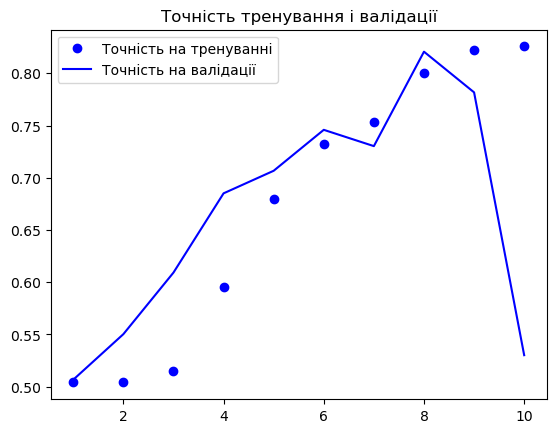

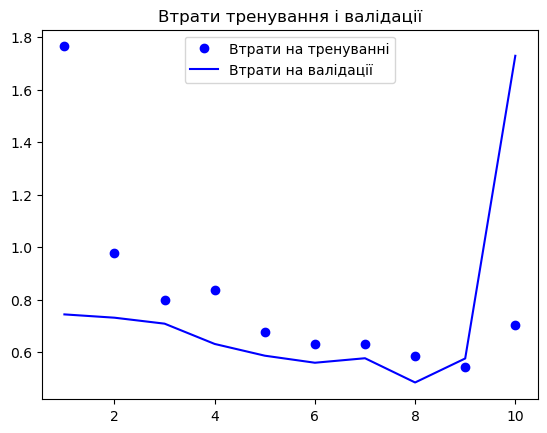

 Prediction 
782/782 ━━━━━━━━━━━━━━━━━━━━ 99s 125ms/step
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
782/782 ━━━━━━━━━━━━━━━━━━━━ 97s 125ms/step - acc: 0.8210 - loss: 0.4721
Test Loss: 0.4765664339065552
Test Accuracy: 0.8216000199317932


In [18]:
summary, hists, test_acc_rate = model_learning(batch_sizes=batch_sizes, epochs=epochs, models=models, optimizers=optimizers, max_features=max_features)

### MinMax kernel reg on both layers

In [19]:
batch_sizes = [128]
epochs= [10]

optimizers = ['rmsprop']

models = {
    'rnn_model' : Sequential([Embedding(max_features, 32, input_length=maxlen),
                              SimpleRNN(units = 64, activation = "tanh", kernel_constraint=MinMaxNorm(min_value=0.0, max_value=2.), return_sequences = True),
                              Dropout(0.5),
                              SimpleRNN(units = 32, activation = "tanh", kernel_constraint=MinMaxNorm(min_value=0.0, max_value=2.), return_sequences = True),
                              Dropout(0.2),
                              SimpleRNN(units = 10, activation = "sigmoid"),
                              Dropout(0.2),
                              Dense(units = 1)])
}

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_6 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_7 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_8 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)



 rnn_model: rmsprop opt, 10 epochs, batch 128 
Epoch 1/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 102s 696ms/step - acc: 0.5016 - loss: 1.6418 - val_acc: 0.5069 - val_loss: 0.6922
Epoch 2/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 139s 675ms/step - acc: 0.5020 - loss: 0.7227 - val_acc: 0.5161 - val_loss: 0.6899
Epoch 3/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 99s 720ms/step - acc: 0.5580 - loss: 0.6989 - val_acc: 0.6557 - val_loss: 0.6122
Epoch 4/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 96s 700ms/step - acc: 0.6693 - loss: 0.7335 - val_acc: 0.6941 - val_loss: 0.5976
Epoch 5/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 96s 702ms/step - acc: 0.7387 - loss: 0.5930 - val_acc: 0.7019 - val_loss: 0.5897
Epoch 6/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 96s 700ms/step - acc: 0.7494 - loss: 0.5496 - val_acc: 0.7300 - val_loss: 0.5659
Epoch 7/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 96s 701ms/step - acc: 0.8000 - loss: 0.5581 - val_acc: 0.6983 - val_loss: 0.6672
Epoch 8/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 98s 713ms/step - acc: 0.7719 - loss: 0.6150 - val_acc: 0.6873 

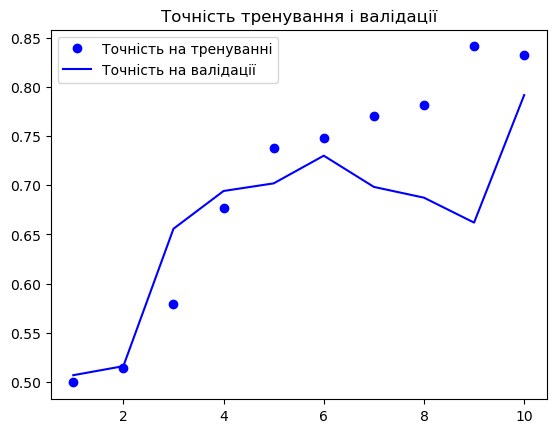

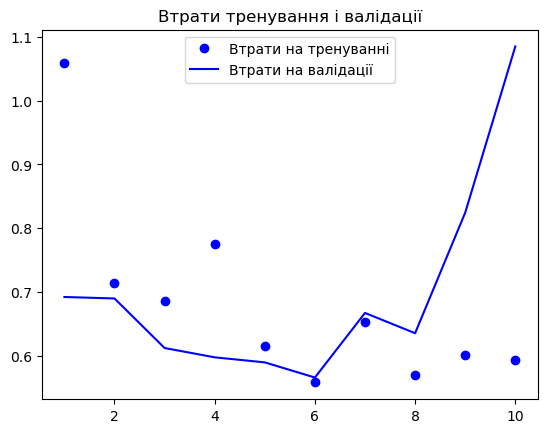

 Prediction 
782/782 ━━━━━━━━━━━━━━━━━━━━ 96s 122ms/step
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
782/782 ━━━━━━━━━━━━━━━━━━━━ 98s 125ms/step - acc: 0.7245 - loss: 0.5628
Test Loss: 0.5619303584098816
Test Accuracy: 0.7264000177383423


In [20]:
summary, hists, test_acc_rate = model_learning(batch_sizes=batch_sizes, epochs=epochs, models=models, optimizers=optimizers, max_features=max_features)

### MinMax kernel reg + l2 - relu

In [21]:
batch_sizes = [128]
epochs= [10]

optimizers = ['rmsprop']

models = {
    'rnn_model' : Sequential([Embedding(max_features, 32, input_length=maxlen),
                              SimpleRNN(units = 64, kernel_constraint=MinMaxNorm(min_value=0.0, max_value=2.), activation = "relu", return_sequences = True),
                              Dropout(0.5),
                              SimpleRNN(units = 32, activation = "relu", kernel_regularizer=l2(0.001), return_sequences = True),
                              Dropout(0.2),
                              SimpleRNN(units = 10, activation = "sigmoid"),
                              Dropout(0.2),
                              Dense(units = 1)])
}

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_9 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_10 (SimpleRNN)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_11 (SimpleRNN)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)



 rnn_model: rmsprop opt, 10 epochs, batch 128 
Epoch 1/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 109s 733ms/step - acc: 0.5097 - loss: 1.2778 - val_acc: 0.5105 - val_loss: 0.7144
Epoch 2/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 99s 723ms/step - acc: 0.5440 - loss: 0.7350 - val_acc: 0.7247 - val_loss: 0.6218
Epoch 3/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 101s 732ms/step - acc: 0.6771 - loss: 0.6965 - val_acc: 0.7852 - val_loss: 0.5097
Epoch 4/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 109s 798ms/step - acc: 0.7316 - loss: 0.6080 - val_acc: 0.7716 - val_loss: 0.5229
Epoch 5/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 100s 733ms/step - acc: 0.7870 - loss: 0.5676 - val_acc: 0.7680 - val_loss: 0.5641
Epoch 6/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 100s 727ms/step - acc: 0.8061 - loss: 0.5182 - val_acc: 0.8185 - val_loss: 0.4636
Epoch 7/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 103s 750ms/step - acc: 0.8359 - loss: 0.5040 - val_acc: 0.8031 - val_loss: 0.6844
Epoch 8/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 101s 733ms/step - acc: 0.8424 - loss: 0.5330 - val_acc: 0.

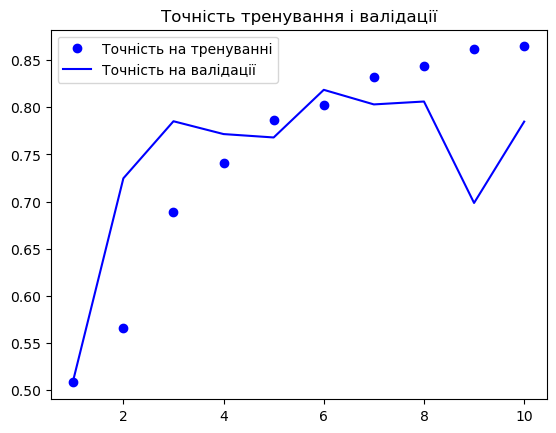

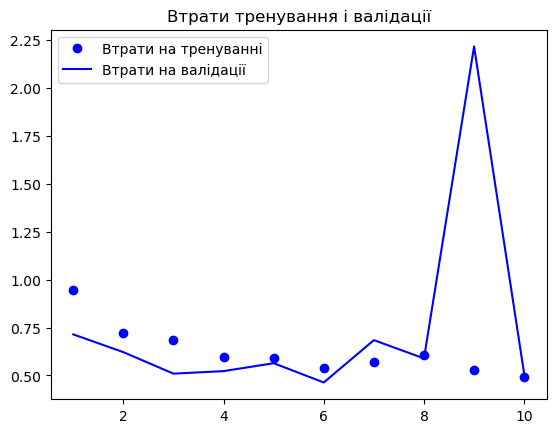

 Prediction 
782/782 ━━━━━━━━━━━━━━━━━━━━ 97s 123ms/step
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
782/782 ━━━━━━━━━━━━━━━━━━━━ 96s 123ms/step - acc: 0.8116 - loss: 0.4632
Test Loss: 0.4589674472808838
Test Accuracy: 0.8136799931526184


In [22]:
summary, hists, test_acc_rate = model_learning(batch_sizes=batch_sizes, epochs=epochs, models=models, optimizers=optimizers, max_features=max_features)

### MinMax kernel reg  on 1st layer- relu

In [23]:
batch_sizes = [128]
epochs= [10]

optimizers = ['rmsprop']

models = {
    'rnn_model' : Sequential([Embedding(max_features, 32, input_length=maxlen),
                              SimpleRNN(units = 64, kernel_constraint=MinMaxNorm(min_value=0.0, max_value=2.), activation = "relu", return_sequences = True),
                              Dropout(0.5),
                              SimpleRNN(units = 32, activation = "relu", return_sequences = True),
                              Dropout(0.2),
                              SimpleRNN(units = 10, activation = "sigmoid"),
                              Dropout(0.2),
                              Dense(units = 1)])
}

In [25]:
summary, hists, test_acc_rate = model_learning(batch_sizes=batch_sizes, epochs=epochs, models=models, optimizers=optimizers, max_features=max_features)

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ (None, 500, 32)        │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_12 (SimpleRNN)       │ (None, 500, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 500, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_13 (SimpleRNN)       │ (None, 500, 32)        │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 500, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_14 (SimpleRNN)       │ (None, 10)             │           430 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,753 (1.26 MB)

 Trainable params: 329,753 (1.26 MB)

 Non-trainable params: 0 (0.00 B)



 rnn_model: rmsprop opt, 10 epochs, batch 128 
Epoch 1/10


2024-07-01 10:17:48.262509: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: indices[0] = 1099055935 is not in [0, 64001)
	 [[{{function_node rmsprop_cond_cond_false_1376711}}{{node rmsprop/cond/cond/GatherV2_1}}]]


InvalidArgumentError: Graph execution error:

Detected at node rmsprop/cond/cond/GatherV2_1 defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/home/stacy/anaconda3/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/stacy/anaconda3/lib/python3.11/site-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/home/stacy/anaconda3/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 701, in start

  File "/home/stacy/anaconda3/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/stacy/anaconda3/lib/python3.11/asyncio/base_events.py", line 607, in run_forever

  File "/home/stacy/anaconda3/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once

  File "/home/stacy/anaconda3/lib/python3.11/asyncio/events.py", line 80, in _run

  File "/home/stacy/anaconda3/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 534, in dispatch_queue

  File "/home/stacy/anaconda3/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 523, in process_one

  File "/home/stacy/anaconda3/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 429, in dispatch_shell

  File "/home/stacy/anaconda3/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 767, in execute_request

  File "/home/stacy/anaconda3/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 429, in do_execute

  File "/home/stacy/anaconda3/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/stacy/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3051, in run_cell

  File "/home/stacy/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3106, in _run_cell

  File "/home/stacy/anaconda3/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/home/stacy/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3311, in run_cell_async

  File "/home/stacy/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3493, in run_ast_nodes

  File "/home/stacy/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "/tmp/ipykernel_162956/1663854661.py", line 1, in <module>

  File "/tmp/ipykernel_162956/1324181574.py", line 30, in model_learning

  File "/home/stacy/anaconda3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/stacy/anaconda3/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 314, in fit

  File "/home/stacy/anaconda3/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 117, in one_step_on_iterator

  File "/home/stacy/anaconda3/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 104, in one_step_on_data

  File "/home/stacy/anaconda3/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 69, in train_step

  File "/home/stacy/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/base_optimizer.py", line 282, in apply_gradients

  File "/home/stacy/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/base_optimizer.py", line 351, in apply

  File "/home/stacy/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/base_optimizer.py", line 405, in _backend_apply_gradients

  File "/home/stacy/anaconda3/lib/python3.11/site-packages/keras/src/backend/tensorflow/optimizer.py", line 119, in _backend_update_step

  File "/home/stacy/anaconda3/lib/python3.11/site-packages/keras/src/backend/tensorflow/optimizer.py", line 135, in _distributed_tf_update_step

  File "/home/stacy/anaconda3/lib/python3.11/site-packages/keras/src/backend/tensorflow/optimizer.py", line 132, in apply_grad_to_update_var

  File "/home/stacy/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/rmsprop.py", line 152, in update_step

  File "/home/stacy/anaconda3/lib/python3.11/site-packages/keras/src/ops/numpy.py", line 5502, in divide

  File "/home/stacy/anaconda3/lib/python3.11/site-packages/keras/src/backend/tensorflow/sparse.py", line 770, in sparse_wrapper

  File "/home/stacy/anaconda3/lib/python3.11/site-packages/keras/src/backend/tensorflow/sparse.py", line 758, in func_for_union_indices

  File "/home/stacy/anaconda3/lib/python3.11/site-packages/keras/src/backend/tensorflow/sparse.py", line 139, in indexed_slices_union_indices_and_values

  File "/home/stacy/anaconda3/lib/python3.11/site-packages/keras/src/backend/tensorflow/sparse.py", line 142, in <lambda>

  File "/home/stacy/anaconda3/lib/python3.11/site-packages/keras/src/backend/tensorflow/sparse.py", line 136, in values_for_union

indices[0] = 1099055935 is not in [0, 64001)
	 [[{{node rmsprop/cond/cond/GatherV2_1}}]] [Op:__inference_one_step_on_iterator_1377059]